#Import necessary libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import zipfile
import os
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop

#Collect a dataset

In [ ]:
# Integration gcolab to Drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/facerecognition.zip'
extract_path = '/content/facerecognition/'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the extracted files to verify
os.listdir(extract_path)

['Testing', 'Training']

In [ ]:
train_dir = os.path.join(extract_path, 'Training/Training')
test_dir = os.path.join(extract_path, 'Testing/Testing')

categories = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']
data_types = ['Training', 'Testing']

dir_list = []
for data_type in data_types:
    for category in categories:
        dir_list.append(os.path.join(extract_path, f'{data_type}/{data_type}', category))

for d in dir_list:
    print(f'{d}: {len(os.listdir(d))} images')

/content/facerecognition/Training/Training/Angry: 3995 images
/content/facerecognition/Training/Training/Fear: 4097 images
/content/facerecognition/Training/Training/Happy: 7215 images
/content/facerecognition/Training/Training/Neutral: 4965 images
/content/facerecognition/Training/Training/Sad: 4830 images
/content/facerecognition/Training/Training/Suprise: 3171 images
/content/facerecognition/Testing/Testing/Angry: 958 images
/content/facerecognition/Testing/Testing/Fear: 1024 images
/content/facerecognition/Testing/Testing/Happy: 1774 images
/content/facerecognition/Testing/Testing/Neutral: 1233 images
/content/facerecognition/Testing/Testing/Sad: 1247 images
/content/facerecognition/Testing/Testing/Suprise: 831 images


#Prepocessing data

In [ ]:
# ImageDataGenerator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


#Build a model

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = True

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = True

# Freeze the first 249 layers and unfreeze the rest
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Increase dropout rate to prevent overfitting
    tf.keras.layers.Dense(6, activation='softmax')
])

Disini pake model sebelumnya karena sudah ada model yang sudah ditraining sebelumnya

In [ ]:
# Load the previously trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/faceexpressionemotion_model.h5')

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 22065830 (84.17 MB)
Trainable params: 11377926 (43.40 MB)
Non-trainable params: 10687904 (40.77 MB)
________

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    verbose=1
)


Epoch 1/10
884/884 [==============================] - 245s 254ms/step - loss: 0.2670 - accuracy: 0.9024 - val_loss: 1.7603 - val_accuracy: 0.6329
Epoch 2/10
884/884 [==============================] - 238s 269ms/step - loss: 0.2687 - accuracy: 0.9038 - val_loss: 1.7188 - val_accuracy: 0.6363
Epoch 3/10
884/884 [==============================] - 217s 245ms/step - loss: 0.2689 - accuracy: 0.9031 - val_loss: 1.7261 - val_accuracy: 0.6484
Epoch 4/10
884/884 [==============================] - 216s 244ms/step - loss: 0.2585 - accuracy: 0.9067 - val_loss: 1.7019 - val_accuracy: 0.6403
Epoch 5/10
884/884 [==============================] - 280s 317ms/step - loss: 0.2594 - accuracy: 0.9053 - val_loss: 1.7246 - val_accuracy: 0.6373
Epoch 6/10
884/884 [==============================] - 257s 291ms/step - loss: 0.2598 - accuracy: 0.9072 - val_loss: 1.7113 - val_accuracy: 0.6434
Epoch 7/10
884/884 [==============================] - 245s 277ms/step - loss: 0.2574 - accuracy: 0.9090 - val_loss: 1.7360 -

#Save model

In [ ]:
# save the model

model.save('/content/drive/MyDrive/faceexpressionemotion.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Training dan validation Loss

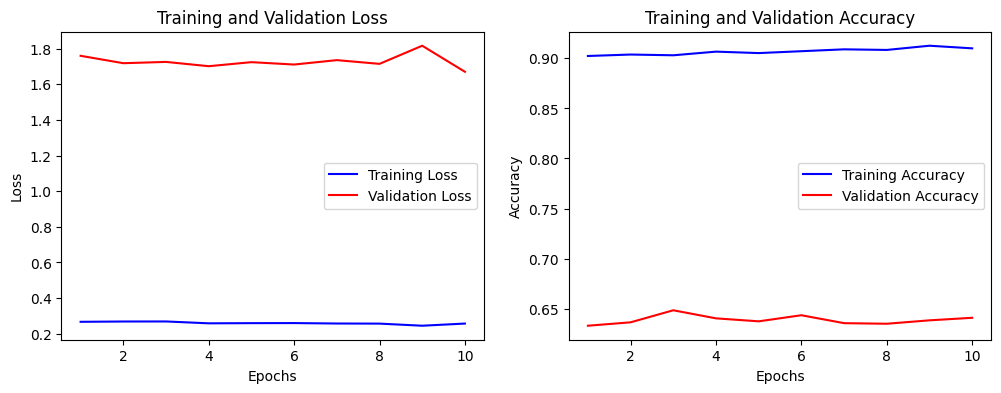

In [ ]:
# Training dan validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Training dan validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# epoch
epochs = range(1, len(train_loss) + 1)

# Plotting Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# show the plot
plt.show()

#Confusion Matrix

221/221 [==============================] - 10s 40ms/step


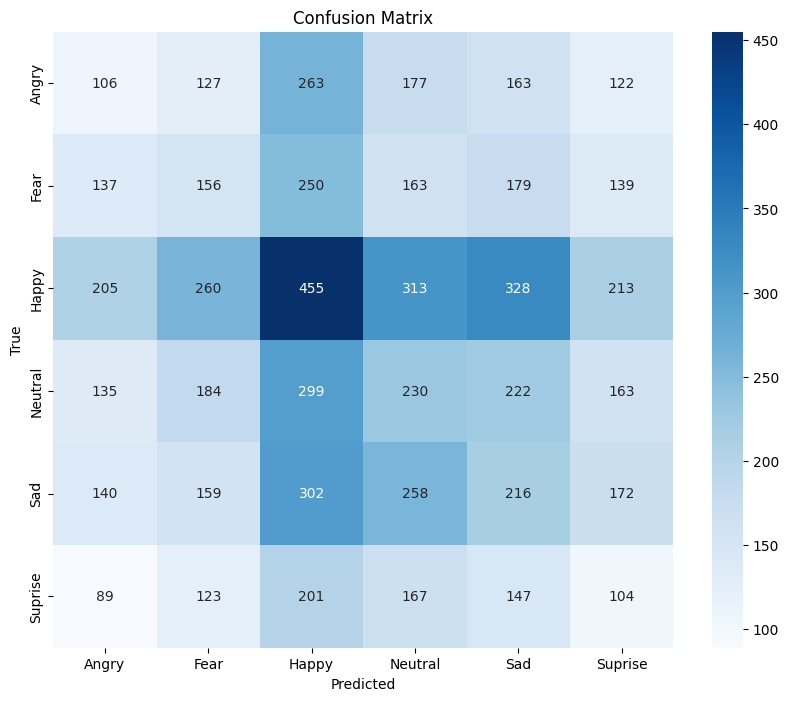

Classification Report
              precision    recall  f1-score   support

       Angry       0.13      0.11      0.12       958
        Fear       0.15      0.15      0.15      1024
       Happy       0.26      0.26      0.26      1774
     Neutral       0.18      0.19      0.18      1233
         Sad       0.17      0.17      0.17      1247
     Suprise       0.11      0.13      0.12       831

    accuracy                           0.18      7067
   macro avg       0.17      0.17      0.17      7067
weighted avg       0.18      0.18      0.18      7067



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions on the test data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

y_true = validation_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=categories))

#Classification

In [ ]:
from random import randint
import cv2

# Prediction results for images
pred_result = []

for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            img_path = os.path.join(root, file)
            img = keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = model.predict(img_array)
            pred_class = categories[np.argmax(prediction)]
            actual_class = os.path.basename(root)
            pred_result.append((img_path, pred_class, actual_class))

pred_result = pd.DataFrame(pred_result, columns=['filename', 'pred_class', 'actual_class'])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step


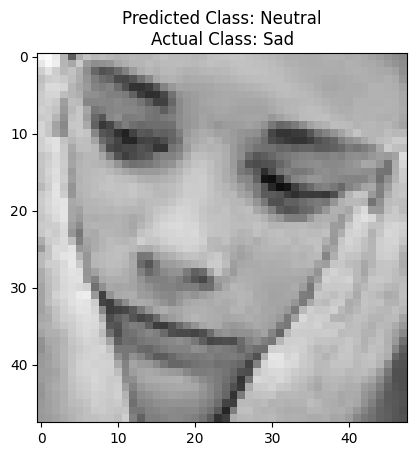

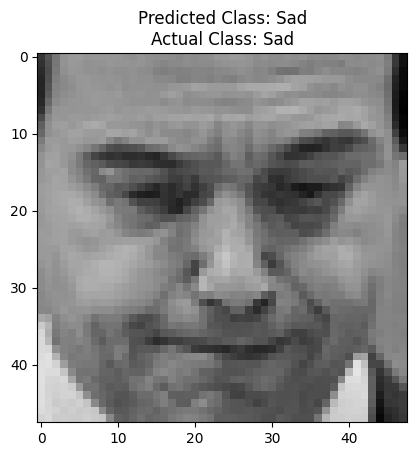

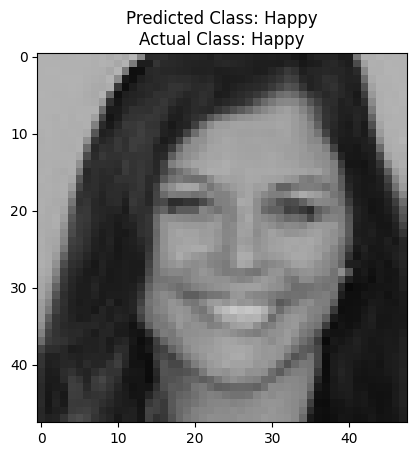

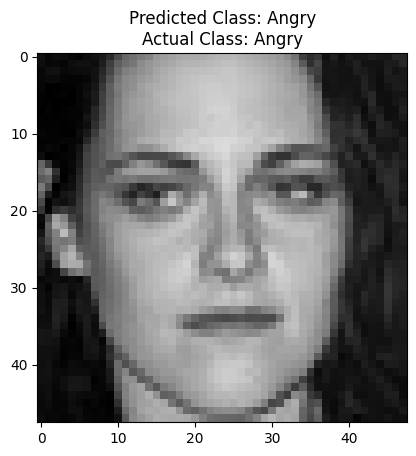

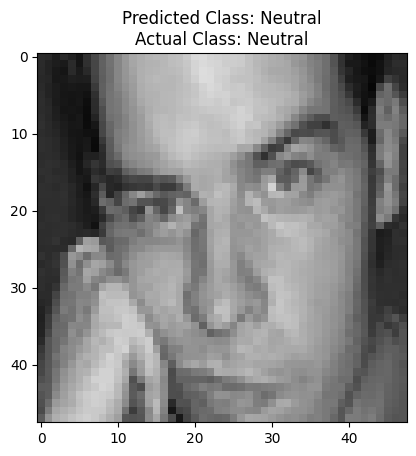

In [ ]:
# Randomly display prediction results
l = len(pred_result)
for i in range(5):  # 5 images
    rnd_number = randint(0, l-1)
    filename, pred_class, actual_class = pred_result.iloc[rnd_number]

    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Predicted Class: {pred_class}\nActual Class: {actual_class}")
    plt.show()

Classification using a new image

Saving ketawa.jpeg to ketawa.jpeg
1/1 [==============================] - 0s 27ms/step
Filename: ketawa.jpeg
Predicted Class: Happy


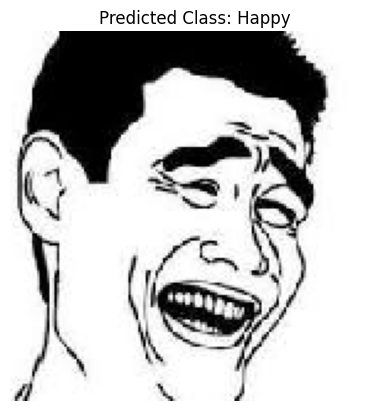

In [ ]:
from google.colab import files
from keras.preprocessing import image

%matplotlib inline

# Upload images
uploaded = files.upload()

# Define class labels
class_labels = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

for fn in uploaded.keys():
    # Load and preprocess the image
    path = fn
    img = image.load_img(path, target_size=(150, 150))  # Adjust target_size to (150, 150)
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0  # Normalize the image as per your training setup

    # Predict the class
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    # Determine the predicted class
    predicted_class = np.argmax(classes[0])
    predicted_label = class_labels[predicted_class]

    # Print the results
    print(f'Filename: {fn}')
    print(f'Predicted Class: {predicted_label}')
    plt.title(f'Predicted Class: {predicted_label}')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

#Convert model to tflite

In [ ]:
# Load the previously trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/faceexpressionemotion.h5')

# Convert model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save model tftile
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model TFLite berhasil dibuat dan disimpan sebagai 'model.tflite'")

Model TFLite berhasil dibuat dan disimpan sebagai 'model.tflite'
